In [9]:
import dask
import pystac_client
import planetary_computer as pc
import stackstac
import dask.array as da
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/spaudel@clarku.edu/proxy/8787/status,
Dashboard: /user/spaudel@clarku.edu/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39131,Workers: 4
Dashboard: /user/spaudel@clarku.edu/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:46147,Total threads: 2
Dashboard: /user/spaudel@clarku.edu/proxy/33891/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:42451,


In [19]:
#Connecting the API 
api_url='https://earth-search.aws.element84.com/v1'
catalog = pystac_client.Client.open(api_url)

#Searching Sentinel-2 surface reflectance scenes in above cateloge where...
datetime=['2017-01-01','2022-12-31']
bbox = (35.16402630997399, 11.240162235950265, 35.17440912681519, 11.249823496541282)
cloud_cover={"eo:cloud_cover":{"lt":50}} #Cloud cover of less than 50%

search = catalog.search(
    collections=['sentinel-2-l2a'],
    bbox=bbox,
    datetime=datetime,
    query=cloud_cover)

#Printing the number of the items from above criteria
items=search.item_collection()
len(items)

350

In [21]:
items = search.item_collection()
len(items)

350

In [7]:
%%time
items = pc.sign(search)
len(items)

CPU times: user 1.18 s, sys: 38.7 ms, total: 1.22 s
Wall time: 1.2 s


350

In [22]:
%%time
stack = stackstac.stack(items, bounds_latlon=bbox, assets=["green", "nir", "scl"])
stack

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [24]:
# Band names are not trivial from the initial query
stack.band
# Using common_name for bands
stack = stack.assign_coords(band=stack.common_name.fillna(stack.band).rename("band"))
stack.band

NameError: name 'stack' is not defined

In [23]:
#Excluding the given scl_values 
scl_values = [3, 8, 9, 10] 
sclmask = 0
for field in scl_values:
    sclmask |= 1 << field

bin(sclmask)

'0b11100001000'

In [24]:
qa = stack.sel(band="scl").astype("uint16")
bad = qa & sclmask  

good = stack.where(bad == 0) 

NameError: name 'stack' is not defined

In [25]:
#Creating the function to calculate ndwi using the filtered value
def ndwi(green, nir):
    return (green - nir) / (green + nir)
filtered_green = good.sel(band="green")
filtered_nir = good.sel(band="nir")

ndwi_stack = ndwi(filtered_green, filtered_nir)

NameError: name 'good' is not defined

In [26]:
mean_ndwi = ndwi_stack.mean(dim=["x", "y"])
mean_ndwi

NameError: name 'ndwi_stack' is not defined

NameError: name 'mean_ndwi' is not defined

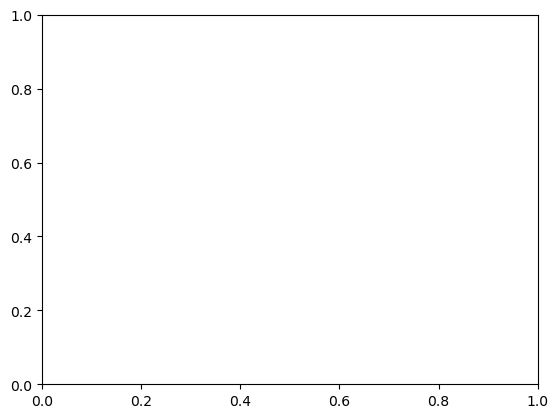

In [27]:
fig,ax = plt.subplots()
ax.scatter(x=mean_ndwi.time, y=mean_ndwi)
ax.set_ylim(-1,1)